Before starting the notebook run this on command:

`module load python`

`conda activate rubin`

`conda install ipykernel`

`ipython kernel install --user --name=rubin`

`conda deactivate`

In order to add rubin into the kernel.

Later on use kernel: `rubin`.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rubin_sim.maf as maf

In [3]:
import sys
sys.path

['/global/u2/q/qhang/desc/notebooks_for_analysis',
 '',
 '/opt/mods/lib/python3.6/site-packages',
 '/opt/ovis/lib/python3.6/site-packages',
 '/global/homes/q/qhang/.conda/envs/rubin/lib/python39.zip',
 '/global/homes/q/qhang/.conda/envs/rubin/lib/python3.9',
 '/global/homes/q/qhang/.conda/envs/rubin/lib/python3.9/lib-dynload',
 '/global/homes/q/qhang/.conda/envs/rubin/lib/python3.9/site-packages',
 '/global/u2/q/qhang/desc/rubin_sim',
 '/global/homes/q/qhang/.conda/envs/rubin/lib/python3.9/site-packages/IPython/extensions',
 '/global/u2/q/qhang/.ipython']

In [4]:
#Accessing the OpSim database used for DC2

runName = 'minion_1016_dc2'
opsdb_file = '/global/cfs/cdirs/descssim/DC2/minion_1016_desc_dithered_v4_trimmed.db'

In [5]:
# The minion_1016 database is old -- it's opsim v3
# The default observations table is 'Summary'
# and the schema uses different column names - exposure MJD is 'expMJD' and the seeing is "FWHMeff", etc
# The other consideration is that Summary may contain duplicates of a given exposure .. however the DESC version 
# is already only unique visits, so no problem there
defaultTable = 'Summary'
colmap = maf.ColMapDict('opsimV3')
# colmap doesn't contain every column -- just the ones which change between versions
colmap['seeingEff'], colmap['mjd']

('FWHMeff', 'expMJD')

In [6]:
colmap.keys()

dict_keys(['ra', 'dec', 'raDecDeg', 'mjd', 'exptime', 'visittime', 'alt', 'az', 'lst', 'filter', 'fiveSigmaDepth', 'night', 'slewtime', 'slewdist', 'seeingEff', 'seeingGeom', 'skyBrightness', 'moonDistance', 'fieldId', 'proposalId', 'slewSpeedsTable', 'slewStatesTable', 'slewActivitiesTable', 'Dome Alt Speed', 'Dome Az Speed', 'Tel Alt Speed', 'Tel Az Speed', 'Rotator Speed', 'Tel Alt', 'Tel Az', 'Rot Tel Pos', 'Dome Alt', 'Dome Az', 'slewactivities', 'metadataList', 'metadataAngleList'])

In [14]:
colmap['exptime']

'visitExpTime'

In [7]:
# And let's identify the DESC dither columns
dithRA = 'descDitheredRA'
dithDec = 'descDitheredDec'
dithRotTelPos = 'descDitheredRotTelPos'

In [8]:
# Set up a healpix slicer .. 
# (we could do this more efficiently at higher resolution that only covers the DC2 patch, 
# but I'm going with this for now)

# HMM - DESC added a dithered rotational position, but we can't use that easily here so going with original rotations
# can set nside with arg
s = maf.HealpixSlicer(lonCol=dithRA, latCol=dithDec, latLonDeg=False, useCache=False)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [9]:
#def the metric here
def generate_standardMetrics_perband(metric_name, constraint, summarystats, slicer, outDir):
    
    """
    
    Global variables:
    runName
    opsdb_file
    resultsDb
    defaultTable
    
    """
    
    # HMM - DESC added a dithered rotational position, but we can't use that easily here so going with original rotations
    # can set nside with arg
    #s = maf.HealpixSlicer(lonCol=dithRA, latCol=dithDec, latLonDeg=False)
    s = slicer
    
    # Calculate a bunch of metrics at each of these points to evaluate the range of airmasses at each point
    metrics = maf.standardMetrics(metric_name)
    if(0):
        print([m.name for m in metrics])
    
    # And then for each of these, we can calculate the mean/max, etc. over the sky 
    # (this means we could calculate the minimum airmass at each point, then figure out the median value of those)
    #summarystats = maf.standardSummary()
    
    
    # Put them together in the metric bundle and run -- could add subselections per filter, etc.
    sql = constraint

    bundleDict = {}
    for m in metrics:
        bundleDict[m.name] = maf.MetricBundle(m, s, sql, summaryMetrics=summarystats, runName=runName)
        
    resultsDb = maf.ResultsDb(outDir)
    g = maf.MetricBundleGroup(bundleDict, opsdb_file, outDir=outDir, resultsDb=resultsDb, dbTable=defaultTable)
    g.runAll()
    
    return bundleDict


def generate_standardMetrics(metric_name_list, constraint_list, summarystats, slicer, outDir):
    for name in metric_name_list:
        for const in constraint_list:
            bundleDict = generate_standardMetrics_perband(name, const, summarystats, slicer, outDir)
    return 0


def generate_Metrics_perband(metric, constraint, summarystats, slicer, outDir):
    """
    
    Global variables:
    runName
    opsdb_file
    resultsDb
    defaultTable
    
    """
    
    #metric = maf.Coaddm5Metric()
    #define the metric bundle here:
    metric_bundle = maf.MetricBundle(
    metric,
    slicer,
    constraint,
    runName=runName,
    )
    
    #define the metric bundle group here:
    resultsDb = maf.ResultsDb(outDir)
    metric_bg = maf.MetricBundleGroup(
        [metric_bundle], opsdb_file, outDir=outDir, resultsDb=resultsDb, dbTable=defaultTable
    )
    metric_bg.runAll()
    
    return metric_bundle


In [14]:
maf.BaseMetric.help()

AGN_TimeLagMetric
AbsMaxMetric
AbsMaxPercentMetric
AbsMeanMetric
AbsMedianMetric
AccumulateCountMetric
AccumulateM5Metric
AccumulateMetric
AccumulateUniformityMetric
ActivityOverPeriodMetric
ActivityOverTimeMetric
AngularSpreadMetric
AreaSummaryMetric
AreaThresholdMetric
AveSlewFracMetric
BDParallaxMetric
BaseChildMetric
BaseMoMetric
BinaryMetric
BruteOSFMetric
CampaignLengthMetric
ChipVendorMetric
Coaddm5Metric
Color_AsteroidMetric
CountExplimMetric
CountMetric
CountRatioMetric
CountSubsetMetric
CountUniqueMetric
CrowdingM5Metric
CrowdingMagUncertMetric
CumulativeMetric
DcrPrecisionMetric
DiscoveryMetric
Discovery_DistanceMetric
Discovery_EcLonLatMetric
Discovery_N_ChancesMetric
Discovery_N_ObsMetric
Discovery_RADecMetric
Discovery_TimeMetric
Discovery_VelocityMetric
ExgalM5
ExgalM5_with_cuts
FftMetric
FracAboveMetric
FracBelowMetric
FullRangeAngleMetric
FullRangeMetric
HighVelocityMetric
HighVelocityNightsMetric
HistogramM5Metric
HistogramMetric
HourglassMetric
IdentityMetric
Instant

TypeError: 'NoneType' object is not subscriptable

In [10]:
# And then for each of these, we can calculate the mean/max, etc. over the sky 
# (this means we could calculate the minimum airmass at each point, then figure out the median value of those)
summarystats = maf.standardSummary()
summarystats

Used `ln -s /global/cscratch1/sd/qhang/rubin_sim_data/ ~/rubin_sim_data` to link the data from scratch.

In [3]:
#metric_name_list = ['airmass']
#metric_name_list = ['FWHMeff']
#metric_name_list = ['solarElong']
#metric_name_list = ['Coadd M5']
if(0):
    constraint_list = [
        '',
        "filter = 'u'",
        "filter = 'g'",
        "filter = 'r'",
        "filter = 'i'",
        "filter = 'z'",
        "filter = 'y'",
    ]
    outDir = '/global/homes/q/qhang/desc_data/minion_1016/desc_maf'


    generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

In [53]:
# metric_name_list = ['airmass']
# metric_name_list = ['normairmass']
# no match found: 'skyBrightness' -> "filtSkyBrightness", 
# 'noonDistance'->"dist2Moon",
#
#metric_name_list = ['fiveSigmaDepth']
metric_name_list = ['filtSkyBrightness', 'dist2Moon']
constraint_list = [
    '',
    "filter = 'u'",
    "filter = 'g'",
    "filter = 'r'",
    "filter = 'i'",
    "filter = 'z'",
    "filter = 'y'",
]
outDir = '/global/homes/q/qhang/desc_data/minion_1016/desc_maf'

generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

Querying table Summary with no constraint for columns ['descDitheredDec', 'descDitheredRA', 'filtSkyBrightness', 'rotSkyPos'].
Found 68446 visits
Running:  ['Mean filtSkyBrightness', 'Median filtSkyBrightness', 'Min filtSkyBrightness', 'Max filtSkyBrightness']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' for columns ['descDitheredDec', 'descDitheredRA', 'filtSkyBrightness', 'rotSkyPos']
Found 8423 visits
Running:  ['Mean filtSkyBrightness', 'Median filtSkyBrightness', 'Min filtSkyBrightness', 'Max filtSkyBrightness']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' for columns ['descDitheredDec', 'descDitheredRA', 'filtSkyBrightness', 'rotSkyPos']
Found 6773 visits
Running:  ['Mean filtSkyBrightness', 'Median filtSkyBrightness', 'Min filtSkyBrightness', 'Max filtSkyBrightness']
Completed metric 

0

In [23]:
metric=maf.Coaddm5Metric()
constraint_list = [
    '',
    "filter = 'u'",
    "filter = 'g'",
    "filter = 'r'",
    "filter = 'i'",
    "filter = 'z'",
    "filter = 'y'",
]
outDir = '/global/homes/q/qhang/desc_data/minion_1016/desc_maf'
for constraint in constraint_list:
    metric_bundle = generate_Metrics_perband(metric, constraint, summarystats, s, outDir)

Querying table Summary with no constraint for columns ['descDitheredDec', 'fiveSigmaDepth', 'descDitheredRA', 'rotSkyPos'].
Found 68446 visits
Running:  ['minion_1016_dc2_CoaddM5_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' for columns ['descDitheredDec', 'fiveSigmaDepth', 'descDitheredRA', 'rotSkyPos']
Found 8423 visits
Running:  ['minion_1016_dc2_CoaddM5_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' for columns ['descDitheredDec', 'fiveSigmaDepth', 'descDitheredRA', 'rotSkyPos']
Found 6773 visits
Running:  ['minion_1016_dc2_CoaddM5_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'r' for columns ['descDitheredDec', 'fiveSigmaDepth', 'descDitheredRA', 'rotSkyPos']
Found 14868 v

In [24]:
metric=maf.ExgalM5()
constraint_list = [
    '',
    "filter = 'u'",
    "filter = 'g'",
    "filter = 'r'",
    "filter = 'i'",
    "filter = 'z'",
    "filter = 'y'",
]
outDir = '/global/homes/q/qhang/desc_data/minion_1016/desc_maf'
for constraint in constraint_list:
    metric_bundle = generate_Metrics_perband(metric, constraint, summarystats, s, outDir)

Querying table Summary with no constraint for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter'].
Found 68446 visits
Running:  ['minion_1016_dc2_ExgalM5_HEAL']


/global/u2/q/qhang/desc/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 8423 visits
Running:  ['minion_1016_dc2_ExgalM5_u_HEAL']


/global/u2/q/qhang/desc/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 6773 visits
Running:  ['minion_1016_dc2_ExgalM5_g_HEAL']


/global/u2/q/qhang/desc/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'r' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 14868 visits
Running:  ['minion_1016_dc2_ExgalM5_r_HEAL']


/global/u2/q/qhang/desc/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'i' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 14899 visits
Running:  ['minion_1016_dc2_ExgalM5_i_HEAL']


/global/u2/q/qhang/desc/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'z' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 11707 visits
Running:  ['minion_1016_dc2_ExgalM5_z_HEAL']


/global/u2/q/qhang/desc/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'y' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 11776 visits
Running:  ['minion_1016_dc2_ExgalM5_y_HEAL']


/global/u2/q/qhang/desc/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:118: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [26]:
metric=maf.ExgalM5_with_cuts()
constraint_list = [
    '',
    "filter = 'u'",
    "filter = 'g'",
    "filter = 'r'",
    "filter = 'i'",
    "filter = 'z'",
    "filter = 'y'",
]
outDir = '/global/homes/q/qhang/desc_data/minion_1016/desc_maf'
for constraint in constraint_list:
    metric_bundle = generate_Metrics_perband(metric, constraint, summarystats, s, outDir)

Querying table Summary with no constraint for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter'].
Found 68446 visits
Running:  ['minion_1016_dc2_ExgalM5_with_cuts_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 8423 visits
Running:  ['minion_1016_dc2_ExgalM5_with_cuts_u_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth', 'filter']
Found 6773 visits
Running:  ['minion_1016_dc2_ExgalM5_with_cuts_g_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'r' for columns ['descDitheredDec', 'd

Extract the same quantities for 1-year observation by setting
`nights<=365`

In [11]:
outDir = '/global/cscratch1/sd/qhang/minion_1016/MAF-1year/desc_maf'

In [38]:
'''
metric_name_list = [
    'airmass', 'normairmass', 
    'dist2Moon', 'fiveSigmaDepth',
    'filtSkyBrightness'
]
'''

#metric_name_list=['solarElong']

constraint_list = [
    'night<=365',
    "filter = 'u' and night<=365",
    "filter = 'g' and night<=365",
    "filter = 'r' and night<=365",
    "filter = 'i' and night<=365",
    "filter = 'z' and night<=365",
    "filter = 'y' and night<=365",
]
#'''
#constraint_list=["filter = 'u' and night<=365"]
#metric_name_list = ['airmass']

generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

Querying table Summary with constraint night<=365 for columns ['descDitheredDec', 'airmass', 'descDitheredRA', 'rotSkyPos']
Found 5799 visits
Running:  ['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=365 for columns ['descDitheredDec', 'airmass', 'descDitheredRA', 'rotSkyPos']
Found 692 visits
Running:  ['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=365 for columns ['descDitheredDec', 'airmass', 'descDitheredRA', 'rotSkyPos']
Found 532 visits
Running:  ['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint fi

0

In [39]:
#for metric in xxx

constraint_list = [
    'night<=365',
    "filter = 'u' and night<=365",
    "filter = 'g' and night<=365",
    "filter = 'r' and night<=365",
    "filter = 'i' and night<=365",
    "filter = 'z' and night<=365",
    "filter = 'y' and night<=365",
]

for metric in [maf.Coaddm5Metric(), maf.ExgalM5(), maf.ExgalM5_with_cuts()]:
    for constraint in constraint_list:
        metric_bundle = generate_Metrics_perband(metric, constraint, summarystats, s, outDir)

Querying table Summary with constraint night<=365 for columns ['descDitheredDec', 'fiveSigmaDepth', 'descDitheredRA', 'rotSkyPos']
Found 5799 visits
Running:  ['minion_1016_dc2_CoaddM5_nightlt365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=365 for columns ['descDitheredDec', 'fiveSigmaDepth', 'descDitheredRA', 'rotSkyPos']
Found 692 visits
Running:  ['minion_1016_dc2_CoaddM5_u_and_nightlt365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=365 for columns ['descDitheredDec', 'fiveSigmaDepth', 'descDitheredRA', 'rotSkyPos']
Found 532 visits
Running:  ['minion_1016_dc2_CoaddM5_g_and_nightlt365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'r' and night<=365 for 

In [10]:
metric_name_list = ['FWHMeff']

constraint_list = [
    'night<=365',
    "filter = 'u' and night<=365",
    "filter = 'g' and night<=365",
    "filter = 'r' and night<=365",
    "filter = 'i' and night<=365",
    "filter = 'z' and night<=365",
    "filter = 'y' and night<=365",
]

generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

Querying table Summary with constraint night<=365 for columns ['descDitheredDec', 'rotSkyPos', 'FWHMeff', 'descDitheredRA']
Found 5799 visits
Running:  ['Mean FWHMeff', 'Median FWHMeff', 'Min FWHMeff', 'Max FWHMeff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=365 for columns ['descDitheredDec', 'rotSkyPos', 'FWHMeff', 'descDitheredRA']
Found 692 visits
Running:  ['Mean FWHMeff', 'Median FWHMeff', 'Min FWHMeff', 'Max FWHMeff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=365 for columns ['descDitheredDec', 'rotSkyPos', 'FWHMeff', 'descDitheredRA']
Found 532 visits
Running:  ['Mean FWHMeff', 'Median FWHMeff', 'Min FWHMeff', 'Max FWHMeff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint fi

0

In [15]:
metric_name_list = ['visitExpTime']

constraint_list = [
    'night<=365',
    "filter = 'u' and night<=365",
    "filter = 'g' and night<=365",
    "filter = 'r' and night<=365",
    "filter = 'i' and night<=365",
    "filter = 'z' and night<=365",
    "filter = 'y' and night<=365",
]

generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

Querying table Summary with constraint night<=365 for columns ['visitExpTime', 'rotSkyPos', 'descDitheredDec', 'descDitheredRA']
Found 5799 visits
Running:  ['Mean visitExpTime', 'Median visitExpTime', 'Min visitExpTime', 'Max visitExpTime']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=365 for columns ['visitExpTime', 'rotSkyPos', 'descDitheredDec', 'descDitheredRA']
Found 692 visits
Running:  ['Mean visitExpTime', 'Median visitExpTime', 'Min visitExpTime', 'Max visitExpTime']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=365 for columns ['visitExpTime', 'rotSkyPos', 'descDitheredDec', 'descDitheredRA']
Found 532 visits
Running:  ['Mean visitExpTime', 'Median visitExpTime', 'Min visitExpTime', 'Max visitExpTime']
Completed metric generation.
Running reduce methods.
Runni

0

In [26]:
#for metric in xxx

constraint_list = [
    'night<=365',
    "filter = 'u' and night<=365",
    "filter = 'g' and night<=365",
    "filter = 'r' and night<=365",
    "filter = 'i' and night<=365",
    "filter = 'z' and night<=365",
    "filter = 'y' and night<=365",
]

#metric=maf.NstarsMetric()
metric=maf.NObsMetric()
for constraint in constraint_list:
    metric_bundle = generate_Metrics_perband(metric, constraint, summarystats, s, outDir)

AttributeError: 'NObsMetric' object has no attribute 'colNameArr'

## Extract the same quantities for 5-year observation by setting `nights<=1825`

In [11]:
print(365*5)

1825


In [27]:
outDir = '/global/cscratch1/sd/qhang/minion_1016/MAF-5year/desc_maf'

In [12]:

metric_name_list = [
    'airmass', 'normairmass', 
    'dist2Moon', 'fiveSigmaDepth',
    'filtSkyBrightness'
]


#metric_name_list=['solarElong']

constraint_list = [
    'night<=1825',
    "filter = 'u' and night<=1825",
    "filter = 'g' and night<=1825",
    "filter = 'r' and night<=1825",
    "filter = 'i' and night<=1825",
    "filter = 'z' and night<=1825",
    "filter = 'y' and night<=1825",
]
#'''
#constraint_list=["filter = 'u' and night<=365"]
#metric_name_list = ['airmass']

generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

Querying table Summary with constraint night<=1825 for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'airmass']
Found 31770 visits
Running:  ['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=1825 for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'airmass']
Found 3860 visits
Running:  ['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=1825 for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'airmass']
Found 3070 visits
Running:  ['Mean airmass', 'Median airmass', 'Min airmass', 'Max airmass']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constra

0

In [14]:

constraint_list = [
    'night<=1825',
    "filter = 'u' and night<=1825",
    "filter = 'g' and night<=1825",
    "filter = 'r' and night<=1825",
    "filter = 'i' and night<=1825",
    "filter = 'z' and night<=1825",
    "filter = 'y' and night<=1825",
]

for metric in [maf.Coaddm5Metric(), maf.ExgalM5(), maf.ExgalM5_with_cuts()]:
    for constraint in constraint_list:
        metric_bundle = generate_Metrics_perband(metric, constraint, summarystats, s, outDir)

Querying table Summary with constraint night<=1825 for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth']
Found 31770 visits
Running:  ['minion_1016_dc2_CoaddM5_nightlt1825_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=1825 for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth']
Found 3860 visits
Running:  ['minion_1016_dc2_CoaddM5_u_and_nightlt1825_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=1825 for columns ['descDitheredDec', 'descDitheredRA', 'rotSkyPos', 'fiveSigmaDepth']
Found 3070 visits
Running:  ['minion_1016_dc2_CoaddM5_g_and_nightlt1825_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'r' and night<

In [15]:
metric_name_list = ['FWHMeff']

constraint_list = [
    'night<=1825',
    "filter = 'u' and night<=1825",
    "filter = 'g' and night<=1825",
    "filter = 'r' and night<=1825",
    "filter = 'i' and night<=1825",
    "filter = 'z' and night<=1825",
    "filter = 'y' and night<=1825",
]

generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

Querying table Summary with constraint night<=1825 for columns ['rotSkyPos', 'descDitheredDec', 'FWHMeff', 'descDitheredRA']
Found 31770 visits
Running:  ['Mean FWHMeff', 'Median FWHMeff', 'Min FWHMeff', 'Max FWHMeff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=1825 for columns ['rotSkyPos', 'descDitheredDec', 'FWHMeff', 'descDitheredRA']
Found 3860 visits
Running:  ['Mean FWHMeff', 'Median FWHMeff', 'Min FWHMeff', 'Max FWHMeff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=1825 for columns ['rotSkyPos', 'descDitheredDec', 'FWHMeff', 'descDitheredRA']
Found 3070 visits
Running:  ['Mean FWHMeff', 'Median FWHMeff', 'Min FWHMeff', 'Max FWHMeff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constra

0

In [28]:
metric_name_list = ['visitExpTime']

constraint_list = [
    'night<=1825',
    "filter = 'u' and night<=1825",
    "filter = 'g' and night<=1825",
    "filter = 'r' and night<=1825",
    "filter = 'i' and night<=1825",
    "filter = 'z' and night<=1825",
    "filter = 'y' and night<=1825",
]

generate_standardMetrics(metric_name_list, constraint_list, summarystats, s, outDir)

Querying table Summary with constraint night<=1825 for columns ['visitExpTime', 'rotSkyPos', 'descDitheredDec', 'descDitheredRA']
Found 31770 visits
Running:  ['Mean visitExpTime', 'Median visitExpTime', 'Min visitExpTime', 'Max visitExpTime']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'u' and night<=1825 for columns ['visitExpTime', 'rotSkyPos', 'descDitheredDec', 'descDitheredRA']
Found 3860 visits
Running:  ['Mean visitExpTime', 'Median visitExpTime', 'Min visitExpTime', 'Max visitExpTime']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table Summary with constraint filter = 'g' and night<=1825 for columns ['visitExpTime', 'rotSkyPos', 'descDitheredDec', 'descDitheredRA']
Found 3070 visits
Running:  ['Mean visitExpTime', 'Median visitExpTime', 'Min visitExpTime', 'Max visitExpTime']
Completed metric generation.
Running reduce methods.

0

0.0 180.0 -180.0 180.0


{'SkyMap': 1, 'Histogram': 2}

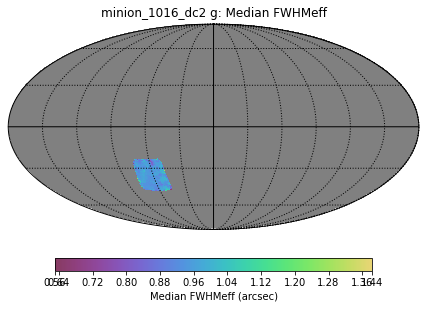

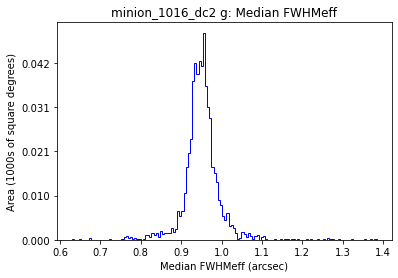

In [40]:
bundleDict['Median FWHMeff'].plot()

In [17]:
# Let's look at those summary stats
pd.DataFrame([bundleDict[k].summaryValues for k in bundleDict], index=list(bundleDict.keys()))

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count
Mean airmass,1.196626,0.020968,1.196974,1.412943,1.002749,26,30,2822
Median airmass,1.177193,0.027106,1.178857,1.416064,1.002749,34,33,2822
Min airmass,1.012093,0.024586,1.003979,1.403240,1.001530,28,0,2822
Max airmass,1.552623,0.216229,1.519328,2.709891,1.002749,92,0,2822


In [18]:
# Another way to look at some of them ..
print('Median minimum airmass', bundleDict['Min airmass'].summaryValues['Median'])
print('Median median airmass', bundleDict['Median airmass'].summaryValues['Median'])
print('Median maximum airmass', bundleDict['Max airmass'].summaryValues['Median'])

Median minimum airmass 1.00397942475
Median median airmass 1.178856905385
Median maximum airmass 1.51932788444


In [28]:
data_dir = '/global/homes/q/qhang/desc_data/minion_1016/desc_maf'

In [32]:
from os import path
#load npz


example1_reloaded = maf.MetricBundle.load(
    path.join(
        data_dir,
        runName + "_Median_airmass_HEAL.npz",
    )
)

#counts/map values
example1_reloaded.metricValues

#bins
#example1_reloaded.slicer.slicePoints

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=-1.6375e+30)